# Modelo con una capa densa

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px

import mysql.connector

from tensorflow.keras.layers import BatchNormalization, Activation

### Llamado de datos

In [2]:
tabla='DAX'
conn = mysql.connector.connect(user='root', password='', host='localhost', database='stock_exchange')
stock = pd.DataFrame(pd.read_sql("SELECT * FROM "+tabla, conn))
conn.close()
stock.head(5)

c:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,index,Date,Open,High,Low,Close,Volume
0,0,2019-01-02,23.521999,23.570,23.420000,23.549999,3700
1,1,2019-01-03,23.490000,23.490,23.209999,23.250000,7000
2,2,2019-01-04,23.580000,24.188,23.580000,24.188000,2600
3,3,2019-01-07,24.180000,24.180,24.042000,24.139999,3400
4,4,2019-01-08,24.330000,24.430,24.228001,24.350000,3600


### Selección de Datos

<AxesSubplot:>

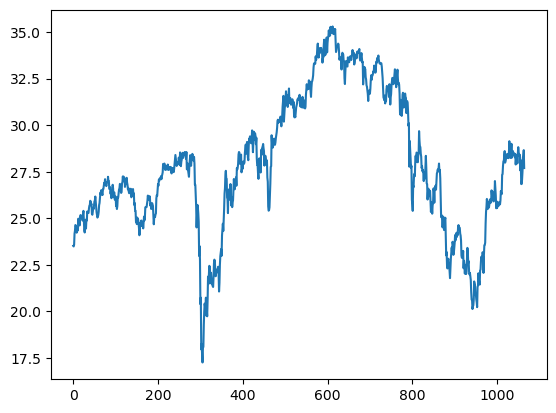

In [3]:
stock['Open'].plot()

In [4]:
time_index=np.array(stock['Date'])
data=np.array(stock['Open'])

### División entre Entrenamiento y Prueba

In [5]:
split_train_test=0.8
Window=6
Batch=32
Shuffle=1000

In [6]:
split_index=int(split_train_test * data.shape[0]) # indice o valor para repartir datos de entrenamiento y prueba
split_index

852

In [7]:
train_data=data[:split_index]
train_time=time_index[:split_index]

test_data=data[split_index:]
test_time=time_index[split_index:]

### Arquitectura del modelo

In [8]:
def preprocessing_ts(data_ds, window_=Window, batch_=Batch):
    ds=tf.data.Dataset.from_tensor_slices(data_ds)
    ds=ds.window(window_+1, shift=1, drop_remainder=True)
    ds=ds.flat_map(lambda win:win.batch(window_+1))
    ds=ds.shuffle(Shuffle).map(lambda win:(win[:-1], win[-1]))
    ds=ds.batch(batch_)
    return ds

In [9]:
train_data_ts=preprocessing_ts(train_data, window_=Window, batch_=Batch)
test_data_ts=preprocessing_ts(test_data, window_=Window, batch_=Batch)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
for ds in train_data_ts.take(1):
    print(ds)

(<tf.Tensor: shape=(32, 6), dtype=float64, numpy=
array([[25.36499977, 25.28000069, 25.29000092, 25.29000092, 25.52000046,
        25.67499924],
       [33.34000015, 33.31000137, 33.33000183, 33.31999969, 33.13999939,
        32.81999969],
       [28.46999931, 28.30999947, 27.70000076, 27.79000092, 27.52000046,
        27.60000038],
       [28.79999924, 28.95000076, 29.27000046, 29.15999985, 29.27000046,
        28.95000076],
       [21.31399918, 21.85000038, 22.57999992, 22.78000069, 22.68000031,
        22.23999977],
       [27.13999939, 27.68000031, 28.35400009, 27.70000076, 26.87000084,
        26.84000015],
       [32.54000092, 32.52999878, 32.20000076, 32.22000122, 32.47000122,
        32.70999908],
       [35.27999878, 35.08000183, 34.95999908, 35.13000107, 35.18000031,
        35.29999924],
       [19.73999977, 20.60000038, 21.87000084, 21.46999931, 22.01000023,
        22.45000076],
       [31.15999985, 31.38999939, 31.36499977, 31.38999939, 31.49500084,
        31.37999916],


In [11]:
from tensorflow.keras import layers
model=tf.keras.models.Sequential(
    [
        layers.Dense(20, input_shape=[Window], activation='relu'),
        layers.Dense(1, activation='relu'),
        layers.Dense(1)
    ]
)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                140       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics='mse')

In [14]:
history=model.fit(train_data_ts, validation_data=test_data_ts, epochs=20, verbose=1)

Epoch 1/20
27/27 [==============================] - 4s 94ms/step - loss: 25.6045 - mse: 692.3279 - val_loss: 21.0827 - val_mse: 470.6765
Epoch 2/20
27/27 [==============================] - 0s 4ms/step - loss: 22.3895 - mse: 533.8527 - val_loss: 17.3783 - val_mse: 323.1140
Epoch 3/20
27/27 [==============================] - 0s 4ms/step - loss: 16.9913 - mse: 313.9708 - val_loss: 11.4282 - val_mse: 144.0994
Epoch 4/20
27/27 [==============================] - 0s 4ms/step - loss: 8.6451 - mse: 93.9382 - val_loss: 2.4523 - val_mse: 9.3027
Epoch 5/20
27/27 [==============================] - 0s 4ms/step - loss: 0.7948 - mse: 2.3632 - val_loss: 0.3388 - val_mse: 0.7411
Epoch 6/20
27/27 [==============================] - 0s 4ms/step - loss: 0.2367 - mse: 0.5594 - val_loss: 0.2379 - val_mse: 0.5164
Epoch 7/20
27/27 [==============================] - 0s 4ms/step - loss: 0.1925 - mse: 0.4745 - val_loss: 0.2420 - val_mse: 0.5315
Epoch 8/20
27/27 [==============================] - 0s 4ms/step - loss

In [15]:
def plot_series(time, series, format="-", start=0, end=None, lab="train"):
    plt.plot(time[start:end], series[start:end], label=lab)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

In [16]:
forecast=[]

for time in range(len(data)-Window):
    forecast.append(model.predict(data[time:time+Window][np.newaxis]))

1/1 [==============================] - 0s 30ms/step


In [17]:
forecast_=forecast[split_index-Window:]
results=np.array(forecast_)[:,0,0]

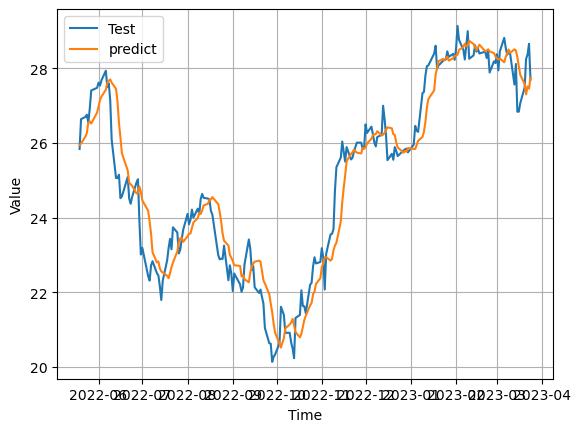

In [18]:
plot_series(test_time, test_data, lab='Test')
plot_series(test_time, results, lab='predict')